In [110]:
import os
import re
import pandas as pd
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [111]:
DATA = "data"
POS = "pos"
NEG = "neg"
ACL_IMDB = "aclImdb"
TRAIN = "train"
TEST = "test"

In [42]:
from nltk.corpus import stopwords

In [99]:
dataset_parts = (TRAIN, TEST)
text_sentiments = (POS, NEG)

filename_parser = re.compile(r"(?P<id>\d+)_(?P<rating>\d{,2}).txt")

train_data_list = []
test_data_list = []

for part in dataset_parts:
    for sentiment in text_sentiments:
        for filename in os.listdir(os.path.join(DATA, ACL_IMDB, part, sentiment)):
            with open(os.path.join(DATA, ACL_IMDB, part, sentiment, filename), "r", encoding="utf-8") as file:
                if part == TRAIN:
                    needed_list = train_data_list
                else:
                    needed_list = test_data_list
                needed_list.append({"text": file.read().strip(),
                                    "sentiment": int(sentiment == POS),
                                    "rating": int(filename_parser.match(filename).group("rating"))})

In [100]:
data_train = pd.DataFrame(train_data_list)
data_test = pd.DataFrame(test_data_list)

In [55]:
stopwords_en = stopwords.words("english")

In [141]:
def tp(y_true, y_pred):
    sum_true = 0
    for true, pred in zip(y_true, y_pred):
        if true and pred:
            sum_true += 1
    return sum_true

def fp(y_true, y_pred):
    sum_fp = 0
    for true, pred in zip(y_true, y_pred):
        if not true and pred:
            sum_fp += 1
    return sum_fp

def tn(y_true, y_pred):
    sum_tn = 0
    for true, pred in zip(y_true, y_pred):
        if not true and not pred:
            sum_tn += 1
    return sum_tn

def fn(y_true, y_pred):
    sum_fn = 0
    for true, pred in zip(y_true, y_pred):
        if true and not pred:
            sum_fn += 1
    return sum_fn

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [145]:
vectorizer = TfidfVectorizer(use_idf=True, min_df=10, max_df=1000, stop_words=stopwords_en)
def evaluate_model(model_class,param_grid):
    grid = GridSearchCV(model_class(), param_grid=param_grid)
    pipeline = Pipeline([("vectorizer", vectorizer),
                         ("grid", grid)])
    pipeline.fit(data_train.text, data_train.sentiment)
    predictions = pipeline.predict(data_test.text)
    probabilities = pipeline.predict_proba(data_test.text)
    current_test_df = pd.DataFrame(data_test.copy())
    current_test_df["probabilities"] = probabilities[:,1]
    print(classification_report(data_test.sentiment, predictions))
    print("SkLearn conf matrix")
    print(confusion_matrix(data_test.sentiment, predictions))
    print("My conf matrix")
    print(f"{tn(data_test.sentiment, predictions)} {fp(data_test.sentiment, predictions)}\n{fn(data_test.sentiment, predictions)} {tp(data_test.sentiment, predictions)}")
    lr_auc = roc_auc_score(data_test.sentiment, predictions)
    lr_fpr, lr_tpr, _ = roc_curve(data_test.sentiment, predictions)
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    print(current_test_df.nlargest(15, columns=["probabilities"]))

# Logistic Regression

/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

SkLearn conf matrix
[[10581  1919]
 [ 2200 10300]]
My conf matrix
10581 1919
2200 10300


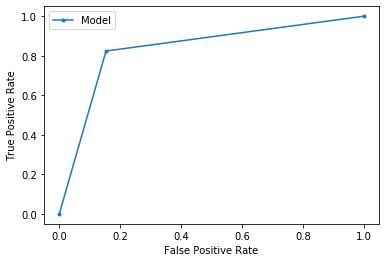

                                                    text  sentiment  rating  \
11328  Easily one of my favourite dramatic TV films, ...          1      10   
1613   Before I saw this film, I read the comment of ...          1       8   
1715   "Here On Earth" is a surprising beautiful roma...          1      10   
2140   From director Billy Wilder (Double Indemnity, ...          1       7   
9713   Making a movie about a Comic is hard to do. Ma...          1      10   
11736  Wow! Fantastic film in my opinion, i wasn't ex...          1       8   
11118  Crossfire is a fantastic film noir that is bot...          1      10   
11311  I've seen a few movies in my time, but this on...          1      10   
6846   This film tackles the subjects of loss, person...          1       9   
630    It was a rare treat to see "Checking Out". I w...          1      10   
11843  Absolutely fantastic! Whatever I say wouldn't ...          1       8   
5694   Edith Nesbitt's best book has been adapted in

In [146]:
evaluate_model(LogisticRegression, dict(tol=[0.000005], solver=["lbfgs"]))

# SGD Classifier

/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.81      0.85      0.83     12500
           1       0.84      0.81      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

SkLearn conf matrix
[[10584  1916]
 [ 2415 10085]]
My conf matrix
10584 1916
2415 10085


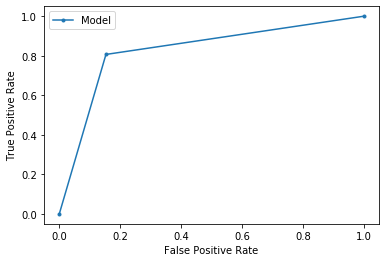

                                                 text  sentiment  rating  \
7   There is no need for me to repeat the synopsis...          1      10   
11  It started off weird, the middle was weird, an...          1       9   
22  Damien O'Donnell has a good track record and i...          1      10   
24  cool flick. enjoyable to watch. hope to see mo...          1       8   
29  The Cure is a fantastic film about a boy with ...          1      10   
31  remember back when this movie was made by robe...          1       8   
36  A strange relationship between a middle-aged w...          1       8   
37  This is a brilliant, lavish Czech film from th...          1       8   
47  I bought my first Zep album in 1974 (at 17) an...          1      10   
57  This film is chock-full of little surprises, m...          1       9   
61  "North & South" the television mini-series is ...          1      10   
71  This show is verging on brilliant. It's a mode...          1      10   
78  I rented

In [147]:
evaluate_model(SGDClassifier, {"loss": ["modified_huber"], "penalty": ["l2", "elasticnet"]})

# Naive Bayes

/Users/grigoriyarshinov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.85      0.82     12500
           1       0.84      0.76      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

SkLearn conf matrix
[[10678  1822]
 [ 2981  9519]]
My conf matrix
10678 1822
2981 9519


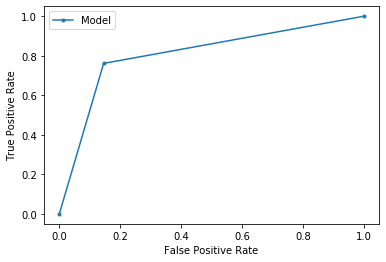

                                                    text  sentiment  rating  \
11328  Easily one of my favourite dramatic TV films, ...          1      10   
140    We all want to fall in love... The experience ...          1       9   
2140   From director Billy Wilder (Double Indemnity, ...          1       7   
6019   This American masterpiece came as near perfect...          1       9   
12009  Although I'm not crazy about musicals, COVER G...          1       7   
6846   This film tackles the subjects of loss, person...          1       9   
3712   We have moved far beyond this tentative foray ...          1       8   
5647   After working on 7 movies with director Mickae...          1      10   
6090   In Dublin, the crippled rebel Rory O'Shea (Jam...          1       8   
5694   Edith Nesbitt's best book has been adapted int...          1      10   
11118  Crossfire is a fantastic film noir that is bot...          1      10   
10715  This has got to be one of the better post-Ast

In [148]:
evaluate_model(MultinomialNB, {"alpha": [0.0001, 0.001, 0.01, 1.0]})